We begin by importing the appropriate modules and configurations. We will use the external package 'contrast' to calculate the clustering statistics. It can be found at https://github.com/epaillas/contrast/tree/master.

In [1]:
from contrast.box import (tpcf_r, tpcf_rmu, project_to_multipoles,
    mean_radial_velocity_r, pdf_radial_velocity_r)
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
rc('text', usetex=True)

We load the galaxy and density split quantile positions, which have been previously computed using the densitysplit package.

In [5]:
# load galaxies
with fits.open('data/mock_data.fits') as hdul:
    mock_data = hdul[1].data
    
xgal = mock_data['X']
ygal = mock_data['Y']
zgal = mock_data['Z']
pos_gal = np.c_[xgal, ygal, zgal]

vxgal = mock_data['VX']
vygal = mock_data['VY']
vzgal = mock_data['VZ']
vel_gal = np.c_[vxgal, vygal, vzgal]

# load quantiles
quantiles = np.load('data/quantiles.npy', allow_pickle=True).item()

We calculate and plot the monopole cross-correlation function between density split quantiles and galaxies.

In [6]:
box_size = 1500
rbins = np.linspace(0, 150, 151)
rbins_c = 0.5*(rbins[1:] + rbins[:-1])

xi_r = {}

for qt in [1, 2, 3, 4, 5]:
    pos_ds = quantiles[f'DS{qt}']

    xi_r[f'DS{qt}'] = tpcf_r(positions1=pos_ds, positions2=pos_gal,
                             box_size=box_size, rbins=rbins, nthreads=4)

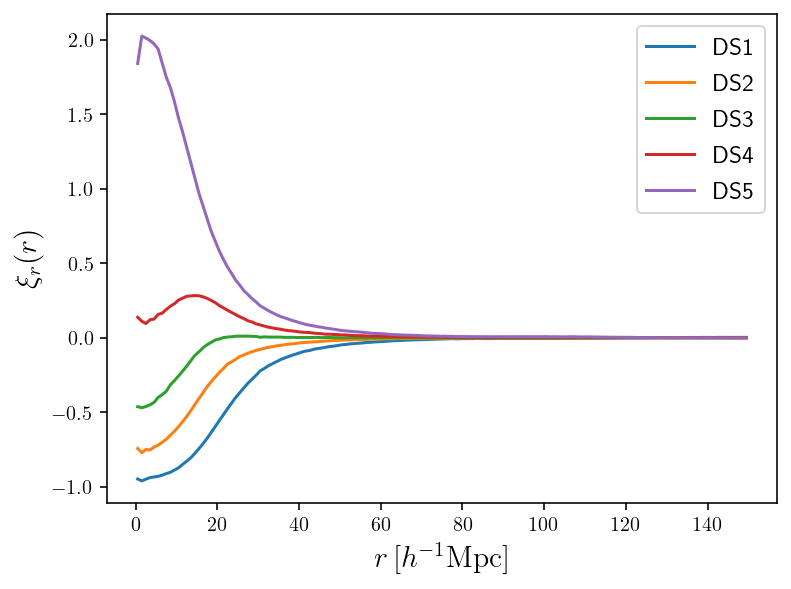

In [7]:
fig, ax = plt.subplots(figsize=(6, 4.5))

for qt in [1, 2, 3, 4, 5]:
    ax.plot(rbins_c, rbins_c**0*xi_r[f'DS{qt}'], label=f'DS{qt}')
    
ax.set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$', fontsize=15)
ax.set_ylabel(r'$\xi_r(r)$', fontsize=15)
ax.legend(fontsize=12)

plt.show()

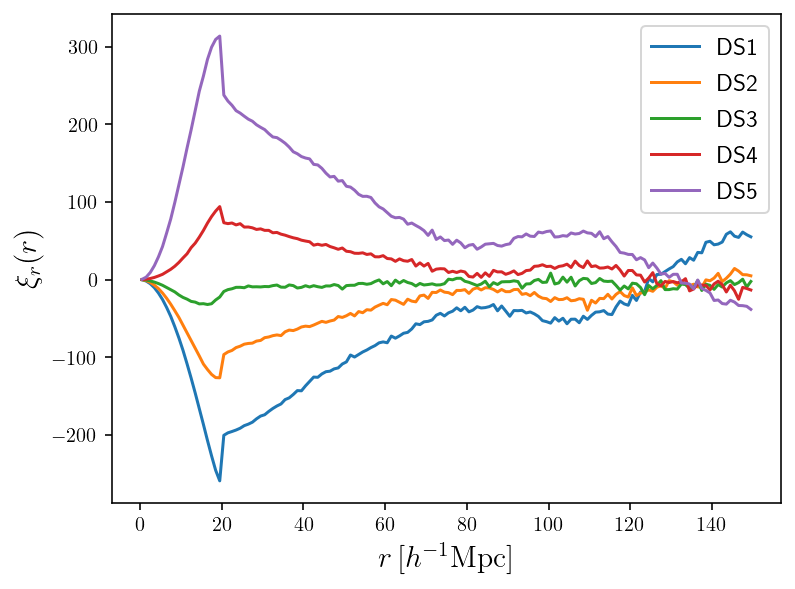

In [4]:
fig, ax = plt.subplots(figsize=(6, 4.5))

for qt in [1, 2, 3, 4, 5]:
    ax.plot(rbins_c, rbins_c**2*xi_r[f'DS{qt}'], label=f'DS{qt}')
    
ax.set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$', fontsize=15)
ax.set_ylabel(r'$\xi_r(r)$', fontsize=15)
ax.legend(fontsize=12)

plt.show()

We can also measure the cross-correlation function in bin of $r$ and $\mu$, and project the result to multipoles. As we are working with the same real-space galaxy catalogue, the monopole $\xi_0$ is just equal to the monopole correlation function we had seen above, whereas the quadrupole is consistent with zero as expected.

In [12]:
mubins = np.linspace(-1, 1, 101)

xi_rmu = {}

for qt in [1, 2, 3, 4, 5]:
    pos_ds = quantiles[f'DS{qt}']

    xi_rmu[f'DS{qt}'] = tpcf_rmu(positions1=pos_ds, positions2=pos_gal, box_size=box_size,
                                 rbins=rbins, mubins=mubins, nthreads=4)

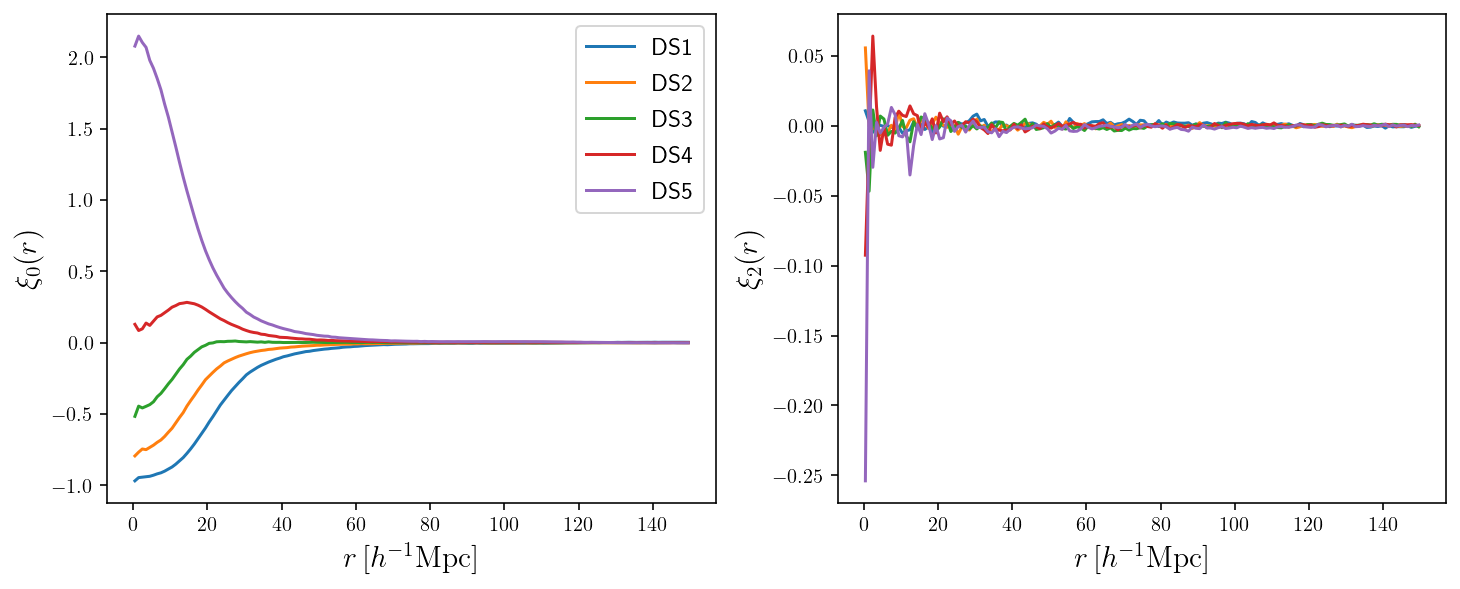

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

for qt in [1, 2, 3, 4, 5]:

    s_c, multipoles = project_to_multipoles(rbins_c, mubins, xi_rmu[f'DS{qt}'])
    xi0, xi2, xi4 = multipoles

    ax[0].plot(s_c, xi0, label=f'DS{qt}')
    ax[1].plot(s_c, xi2, label=f'DS{qt}')
    
ax[0].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$', fontsize=15)
ax[1].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$', fontsize=15)
ax[0].set_ylabel(r'$\xi_0(r)$', fontsize=15)
ax[1].set_ylabel(r'$\xi_2(r)$', fontsize=15)
ax[0].legend(fontsize=12)
plt.show()

We can compute velocity statistics, such as the pairwise radial velocity as a function of the radial separation $r$.

In [ ]:
v_r = {}

for qt in [1, 2, 3, 4, 5]:
    pos_ds = quantiles[f'DS{qt}']
    vel_ds = np.zeros(np.shape(pos_ds))

    v_r[f'DS{qt}'] = mean_radial_velocity_r(positions1=pos_ds, positions2=pos_gal,
                        velocities1=vel_ds, velocities2=vel_gal, box_size=box_size,
                        rbins=rbins, nthreads=4)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4.5))

for qt in [1, 2, 3, 4, 5]:
    ax.plot(rbins_c, v_r[f'DS{qt}'], label=f'DS{qt}')
    
ax.set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$', fontsize=15)
ax.set_ylabel(r'$v_r(r)\,[\rm{km/s}]$', fontsize=15)
ax.legend(fontsize=12)

plt.show()

Instead of the calculating the mean of the pairs, we can get the PDF of pairwise velocities as a function of scale.

**Note:** you might want to get the PDF for only a few radial bins of interest, since the memory requirements will grow larger as you add more bins.

In [ ]:
rbins = np.linspace(15, 25, 11)

pdf_v_r = {}

for qt in [1, 2, 3, 4, 5]:
    pos_ds = quantiles[f'DS{qt}']
    vel_ds = np.zeros(np.shape(pos_ds))

    pdf_v_r[f'DS{qt}'] = pdf_radial_velocity_r(positions1=pos_ds, positions2=pos_gal,
                        velocities1=vel_ds, velocities2=vel_gal, box_size=box_size,
                        rbins=rbins, nthreads=4)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4.5))

for qt in [1, 5]:
    ax.hist(pdf_v_r[f'DS{qt}'][:, 0], label=f'DS{qt}', bins=60, density=True, alpha=0.7)
    
ax.set_xlabel(r'$v_r(R = 15\,h^{-1}{\rm Mpc})$', fontsize=15)
ax.set_ylabel(r'${\rm PDF}$', fontsize=15)
ax.legend(fontsize=12)
ax.set_xlim(-1300, 1300)

plt.show()